In [1]:
import pandas as pd
import numpy as np
import os
# Save df_final as a .csv file
os.chdir(r'D:\sample_dataset')
df_augmented_data=pd.read_csv('augmented_dataset.csv', low_memory=False)

In [2]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import mutual_info_classif

In [3]:
# Separate the target column ('Label') and features
X = df_augmented_data.drop('Label', axis=1).values  # Features (all columns except the target 'Label')
y = df_augmented_data['Label'].values  # Target column ('Label')

# Normalize the numerical features (if not done already)
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [5]:
# Define the fitness function for feature selection based on mutual information
def fitness_function(mask):
    selected_features = np.where(mask == 1)[0]
    if len(selected_features) == 0:
        return 0  # No features selected, so fitness is zero
    
    X_selected = X[:, selected_features]
    mi = mutual_info_classif(X_selected, y, discrete_features='auto')
    return np.sum(mi)  # Maximize the sum of mutual information of selected features

# Define the constraint violation function (if any)
def constraint_violation(mask):
    return 0  # No constraints in this case

# Initialize parameters
N = 1  # Population size
d = X.shape[1]  # Dimensionality of the problem (number of features)
T = 1  # Maximum iterations
T_th = 0.5  # Temperature threshold
α = 0.1  # Seasonal activity factor
β = 0.5  # Reversal factor
γ = 0.1  # Learning rate
δ = 0.01  # Step size
ε = 0.1  # Social factor
λ = 10  # Penalty coefficient
η = 0.5  # Crossover coefficient
convergence_threshold = 1e-6  # Convergence threshold for fitness improvement
no_improvement_limit = 10  # Number of iterations to wait for improvement before stopping

# Initialize population
P = np.random.randint(0, 2, (N, d))  # Binary mask for feature selection

# Evaluate initial fitness
fitness = np.array([fitness_function(mask) for mask in P])
penalized_fitness = fitness - λ * np.array([constraint_violation(mask) for mask in P])

# Main IMOA loop
t = 0
no_improvement_count = 0
best_fitness = np.max(penalized_fitness)
best_solution = P[np.argmax(penalized_fitness)]

while t < T and no_improvement_count < no_improvement_limit:
    for i in range(N):
        # Seasonal Abundance
        α_t = α * np.sin(2 * np.pi * t / T)
        P[i] = np.clip(P[i] + α_t * np.random.uniform(-1, 1, d), 0, 1).astype(int)
        
        # Obstacle Avoidance
        if penalized_fitness[i] < np.mean(penalized_fitness):
            P[i] = np.clip(P[i] - β * np.random.uniform(-1, 1, d), 0, 1).astype(int)
        
        # Temperature Response
        if np.random.uniform(0, 1) > T_th:
            best_idx = np.argmax(penalized_fitness)
            P[i] = np.clip(P[i] + γ * (P[best_idx] - P[i]), 0, 1).astype(int)
        
        # Resource Utilization
        gradient = (fitness_function(P[i] + δ) - fitness_function(P[i])) / δ
        P[i] = np.clip(P[i] + δ * gradient, 0, 1).astype(int)
        
        # Group Movement
        P[i] = np.clip(P[i] + ε * (np.mean(P, axis=0) - P[i]), 0, 1).astype(int)
        
        # Defensive Behavior
        if penalized_fitness[i] < np.mean(penalized_fitness):
            penalized_fitness[i] -= λ * constraint_violation(P[i])
        
        # Mating Behavior
        mate_idx = np.random.randint(N)
        P[i] = np.clip(η * P[i] + (1 - η) * P[mate_idx], 0, 1).astype(int)
        
        # Predator Avoidance
        if np.std(P) < 1e-6:
            P[i] = np.random.randint(0, 2, d)
    
    # Evaluate fitness of new positions
    fitness = np.array([fitness_function(mask) for mask in P])
    penalized_fitness = fitness - λ * np.array([constraint_violation(mask) for mask in P])
    
    # Check for convergence
    current_best_fitness = np.max(penalized_fitness)
    if current_best_fitness > best_fitness + convergence_threshold:
        best_fitness = current_best_fitness
        best_solution = P[np.argmax(penalized_fitness)]
        no_improvement_count = 0
    else:
        no_improvement_count += 1
    
    # Increment iteration counter
    t += 1

# Get selected features based on the best solution
selected_features = np.where(best_solution == 1)[0]



In [6]:
print("Selected features:", selected_features)

Selected features: [ 0  1  2  3  4  5  8  9 10 15 16 17 18 20]


In [8]:
selected_features=[ 0 , 1,  2,  3,  4,  5,  8,  9, 10, 15, 16, 17, 18, 20]

In [9]:
# Convert indices in selected_features to column names
selected_feature_names = df_augmented_data.columns[selected_features]
selected_feature_names

Index(['frame.time', 'frame.time_epoch', 'frame.time_delta',
       'frame.time_delta_displayed', 'frame.time_relative', 'frame.len',
       'ip.hdr_len', 'ip.dsfield.dscp', 'ip.dsfield.ecn', 'ip.flags.df',
       'ip.flags.mf', 'ip.ttl', 'ip.src', 'ip.dst'],
      dtype='object')

In [13]:
# Convert indices in selected_features to column names
selected_feature_names = df_augmented_data.columns[selected_features]

# Select the features and labels using the column names
X = df_augmented_data[selected_feature_names].values
y = df_augmented_data['Label'].values  

In [14]:
X.shape

(1504000, 14)

In [12]:

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Conv1D, Flatten, concatenate, Dropout, Multiply, Reshape, BatchNormalization, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [16]:
X_train.shape

(1203200, 14)

In [17]:
X_test.shape

(300800, 14)

In [18]:
# Convert the multiclass labels to binary labels
y_train_binary = np.where(y_train == 0, 0, 1)
y_test_binary = np.where(y_test == 0, 0, 1)


In [19]:
y_train_binary

array([1, 0, 0, ..., 0, 0, 0])

In [20]:
# Reshape for CNN and LSTM models
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [21]:
from tensorflow.keras.layers import Layer, Dense, Multiply, Reshape, Input, concatenate


In [22]:
# Define CNN Model
def create_cnn_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = GlobalAveragePooling1D()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, output)
    return model

In [23]:
# Define LSTM Model
def create_lstm_model(input_shape):
    inputs = Input(shape=input_shape)
    x = LSTM(64, return_sequences=True)(inputs)
    x = BatchNormalization()(x)
    x = LSTM(32)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, output)
    return model

In [24]:
# Define FNN Model
def create_fnn_model(input_shape):
    inputs = Input(shape=(input_shape,))
    x = Dense(128, activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, output)
    return model

In [25]:
# Define attention mechanism
def attention_mechanism(inputs):
    attention_weights = Dense(inputs.shape[-1], activation='softmax', name='attention_weights')(inputs)
    attention_output = Multiply(name='attention_output')([inputs, attention_weights])
    return attention_output, attention_weights

In [26]:
# Create individual models
input_shape_cnn = (X_train_cnn.shape[1], 1)
input_shape_lstm = (X_train_cnn.shape[1], 1)
input_shape_fnn = X_train.shape[1]  # 10 features

In [27]:
cnn_model = create_cnn_model(input_shape_cnn)
lstm_model = create_lstm_model(input_shape_lstm)
fnn_model = create_fnn_model(input_shape_fnn)

In [28]:
# Compile the individual models
cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
fnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


In [29]:
# Fit the individual models
cnn_history = cnn_model.fit(X_train_cnn, y_train_binary, validation_split=0.2, epochs=10, batch_size=64)

Epoch 1/10
15040/15040 ━━━━━━━━━━━━━━━━━━━━ 75s 5ms/step - accuracy: 0.9246 - loss: 0.1966 - val_accuracy: 0.9357 - val_loss: 0.1653
Epoch 2/10
15040/15040 ━━━━━━━━━━━━━━━━━━━━ 75s 5ms/step - accuracy: 0.9389 - loss: 0.1522 - val_accuracy: 0.9387 - val_loss: 0.1396
Epoch 3/10
15040/15040 ━━━━━━━━━━━━━━━━━━━━ 78s 5ms/step - accuracy: 0.9413 - loss: 0.1432 - val_accuracy: 0.9371 - val_loss: 0.1445
Epoch 4/10
15040/15040 ━━━━━━━━━━━━━━━━━━━━ 83s 5ms/step - accuracy: 0.9426 - loss: 0.1378 - val_accuracy: 0.9458 - val_loss: 0.1397
Epoch 5/10
15040/15040 ━━━━━━━━━━━━━━━━━━━━ 83s 5ms/step - accuracy: 0.9441 - loss: 0.1359 - val_accuracy: 0.9486 - val_loss: 0.1262
Epoch 6/10
15040/15040 ━━━━━━━━━━━━━━━━━━━━ 79s 5ms/step - accuracy: 0.9446 - loss: 0.1323 - val_accuracy: 0.9451 - val_loss: 0.1401
Epoch 7/10
15040/15040 ━━━━━━━━━━━━━━━━━━━━ 77s 5ms/step - accuracy: 0.9431 - loss: 0.1377 - val_accuracy: 0.9475 - val_loss: 0.1268
Epoch 8/10
15040/15040 ━━━━━━━━━━━━━━━━━━━━ 79s 5ms/step - accuracy: 

In [30]:
lstm_history = lstm_model.fit(X_train_cnn, y_train_binary, validation_split=0.2, epochs=10, batch_size=64)

Epoch 1/10
15040/15040 ━━━━━━━━━━━━━━━━━━━━ 397s 26ms/step - accuracy: 0.9240 - loss: 0.1783 - val_accuracy: 0.9486 - val_loss: 0.1155
Epoch 2/10
15040/15040 ━━━━━━━━━━━━━━━━━━━━ 402s 27ms/step - accuracy: 0.9560 - loss: 0.1062 - val_accuracy: 0.9650 - val_loss: 0.0840
Epoch 3/10
15040/15040 ━━━━━━━━━━━━━━━━━━━━ 399s 27ms/step - accuracy: 0.9651 - loss: 0.0845 - val_accuracy: 0.9646 - val_loss: 0.0745
Epoch 4/10
15040/15040 ━━━━━━━━━━━━━━━━━━━━ 399s 26ms/step - accuracy: 0.9693 - loss: 0.0716 - val_accuracy: 0.9724 - val_loss: 0.0649
Epoch 5/10
15040/15040 ━━━━━━━━━━━━━━━━━━━━ 451s 27ms/step - accuracy: 0.9722 - loss: 0.0653 - val_accuracy: 0.9467 - val_loss: 0.1089
Epoch 6/10
15040/15040 ━━━━━━━━━━━━━━━━━━━━ 425s 28ms/step - accuracy: 0.9749 - loss: 0.0598 - val_accuracy: 0.9775 - val_loss: 0.0557
Epoch 7/10
15040/15040 ━━━━━━━━━━━━━━━━━━━━ 544s 35ms/step - accuracy: 0.9769 - loss: 0.0554 - val_accuracy: 0.9804 - val_loss: 0.0480
Epoch 8/10
15040/15040 ━━━━━━━━━━━━━━━━━━━━ 434s 29ms/s

In [31]:
fnn_history = fnn_model.fit(X_train, y_train_binary, validation_split=0.2, epochs=10, batch_size=64)

Epoch 1/10
15040/15040 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - accuracy: 0.9122 - loss: 0.2850 - val_accuracy: 0.9143 - val_loss: 0.2754
Epoch 2/10
15040/15040 ━━━━━━━━━━━━━━━━━━━━ 43s 3ms/step - accuracy: 0.9149 - loss: 0.2733 - val_accuracy: 0.9143 - val_loss: 0.2713
Epoch 3/10
15040/15040 ━━━━━━━━━━━━━━━━━━━━ 46s 3ms/step - accuracy: 0.9147 - loss: 0.2736 - val_accuracy: 0.9143 - val_loss: 0.2702
Epoch 4/10
15040/15040 ━━━━━━━━━━━━━━━━━━━━ 52s 3ms/step - accuracy: 0.9143 - loss: 0.2736 - val_accuracy: 0.9142 - val_loss: 0.2712
Epoch 5/10
15040/15040 ━━━━━━━━━━━━━━━━━━━━ 55s 4ms/step - accuracy: 0.9155 - loss: 0.2703 - val_accuracy: 0.9143 - val_loss: 0.2850
Epoch 6/10
15040/15040 ━━━━━━━━━━━━━━━━━━━━ 60s 4ms/step - accuracy: 0.9147 - loss: 0.2740 - val_accuracy: 0.9143 - val_loss: 0.2724
Epoch 7/10
15040/15040 ━━━━━━━━━━━━━━━━━━━━ 61s 4ms/step - accuracy: 0.9147 - loss: 0.2745 - val_accuracy: 0.9143 - val_loss: 0.2707
Epoch 8/10
15040/15040 ━━━━━━━━━━━━━━━━━━━━ 58s 4ms/step - accuracy: 

In [32]:
# Get validation accuracy for dynamic weighting
cnn_val_accuracy = cnn_model.evaluate(X_test_cnn, y_test, verbose=0)[1]
lstm_val_accuracy = lstm_model.evaluate(X_test_cnn, y_test, verbose=0)[1]
fnn_val_accuracy = fnn_model.evaluate(X_test, y_test, verbose=0)[1]


In [33]:
# Calculate dynamic weights based on validation accuracy
total_accuracy = cnn_val_accuracy + lstm_val_accuracy + fnn_val_accuracy
weights = {
    'cnn': cnn_val_accuracy / total_accuracy,
    'lstm': lstm_val_accuracy / total_accuracy,
    'fnn': fnn_val_accuracy / total_accuracy
}


In [34]:
from tensorflow.keras.layers import Lambda

In [35]:
# Weighted outputs using Lambda layers
cnn_weighted_output = Lambda(lambda x: x * weights['cnn'])(cnn_model.output)
lstm_weighted_output = Lambda(lambda x: x * weights['lstm'])(lstm_model.output)
fnn_weighted_output = Lambda(lambda x: x * weights['fnn'])(fnn_model.output)

In [36]:
# Combine weighted outputs
combined = concatenate([cnn_weighted_output, lstm_weighted_output, fnn_weighted_output], name='combined_features')

# Ensure combined shape is correct (40 features)
combined = Dense(14, activation='relu')(combined)  # To ensure output shape is 40 features

# Apply attention mechanism on combined output
attention_output, attention_weights = attention_mechanism(combined)

# Final output layer
output = Dense(1, activation='sigmoid', name='output_layer')(attention_output)

# Define the complete ensemble model
ensemble_model = Model(inputs=[cnn_model.input, lstm_model.input, fnn_model.input], outputs=output)

# Compile the ensemble model
ensemble_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


In [37]:
# Train the ensemble model
early_stopping = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True)

history = ensemble_model.fit(
    [X_train_cnn, X_train_cnn, X_train],
    y_train_binary,
    validation_data=([X_test_cnn, X_test_cnn, X_test], y_test_binary),
    epochs=50,
    batch_size=128,
    callbacks=[early_stopping]
)

Epoch 1/50
9400/9400 ━━━━━━━━━━━━━━━━━━━━ 355s 37ms/step - accuracy: 0.9637 - loss: 0.1511 - val_accuracy: 0.9718 - val_loss: 0.0579
Epoch 2/50
9400/9400 ━━━━━━━━━━━━━━━━━━━━ 348s 37ms/step - accuracy: 0.9826 - loss: 0.0407 - val_accuracy: 0.9743 - val_loss: 0.0753
Epoch 3/50
9400/9400 ━━━━━━━━━━━━━━━━━━━━ 353s 38ms/step - accuracy: 0.9837 - loss: 0.0391 - val_accuracy: 0.9854 - val_loss: 0.0359
Epoch 4/50
9400/9400 ━━━━━━━━━━━━━━━━━━━━ 358s 38ms/step - accuracy: 0.9846 - loss: 0.0372 - val_accuracy: 0.9786 - val_loss: 0.0560
Epoch 5/50
9400/9400 ━━━━━━━━━━━━━━━━━━━━ 345s 37ms/step - accuracy: 0.9838 - loss: 0.0390 - val_accuracy: 0.9824 - val_loss: 0.0387
Epoch 6/50
9400/9400 ━━━━━━━━━━━━━━━━━━━━ 371s 35ms/step - accuracy: 0.9856 - loss: 0.0357 - val_accuracy: 0.9794 - val_loss: 0.0671
Epoch 7/50
9400/9400 ━━━━━━━━━━━━━━━━━━━━ 381s 41ms/step - accuracy: 0.9867 - loss: 0.0333 - val_accuracy: 0.9888 - val_loss: 0.0276
Epoch 8/50
9400/9400 ━━━━━━━━━━━━━━━━━━━━ 467s 50ms/step - accuracy: 

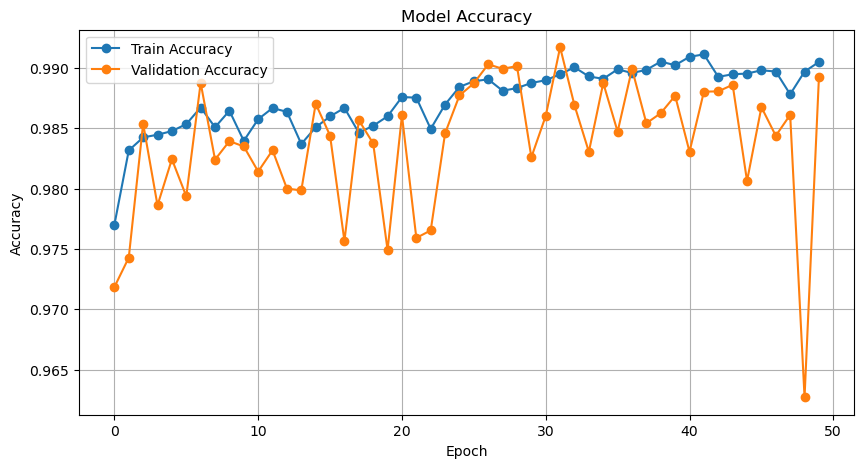

In [38]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig("H23Q_Accuracy_binary.png")
plt.show()

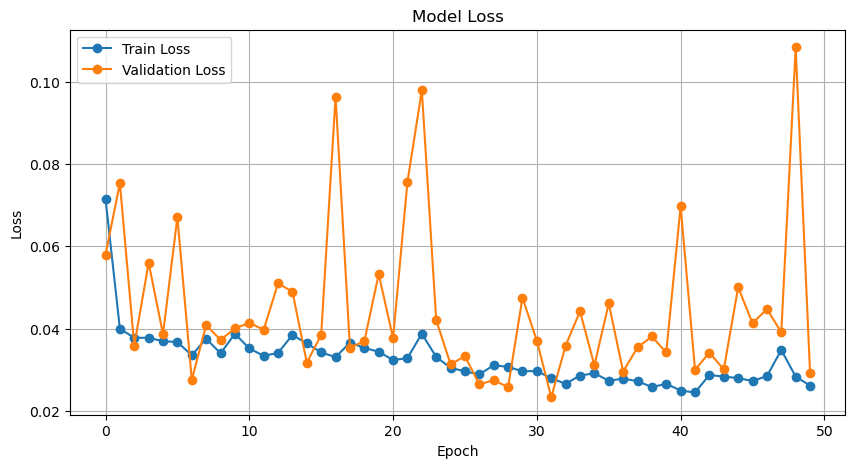

In [39]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig("H23Q_loss_binary.png")
plt.show()

9400/9400 ━━━━━━━━━━━━━━━━━━━━ 81s 9ms/step


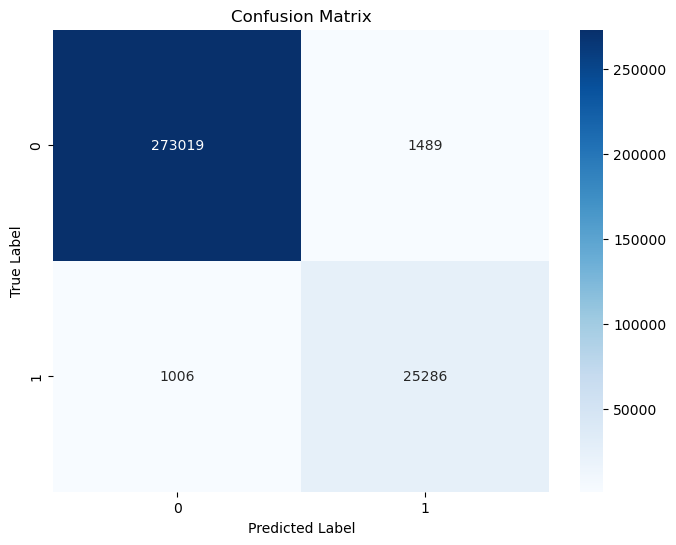

In [40]:
# Confusion matrix
y_pred = (ensemble_model.predict([X_test_cnn, X_test_cnn, X_test]) > 0.5).astype("int32")
cm = confusion_matrix(y_test_binary, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.savefig('H23Q_confusion_matrix_binary.png')
plt.show()

In [41]:
# Classification report
report = classification_report(y_test_binary,  y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.99      1.00    274508
           1       0.94      0.96      0.95     26292

    accuracy                           0.99    300800
   macro avg       0.97      0.98      0.97    300800
weighted avg       0.99      0.99      0.99    300800



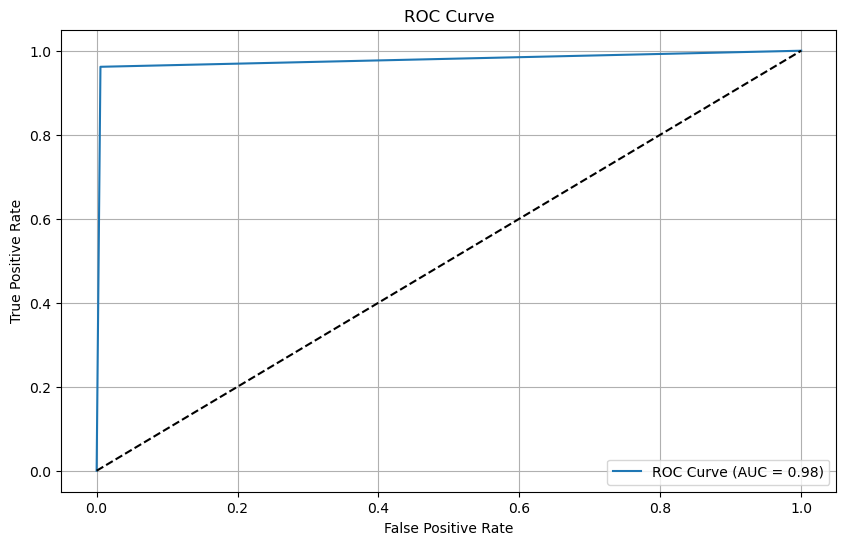

In [42]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test_binary,  y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig("H23Q_ROC_binary.png")
plt.show()


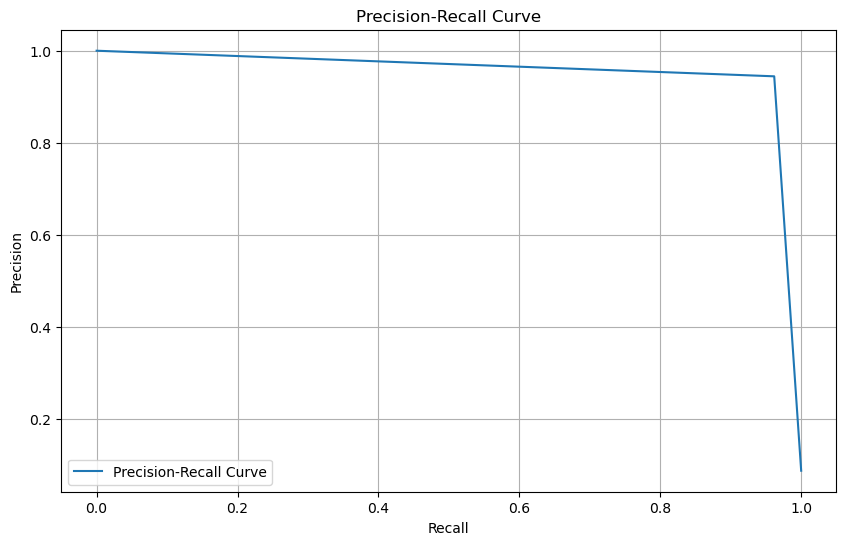

In [43]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test_binary,  y_pred)
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.grid(True)
plt.savefig("H23Q_recall_binary.png")
plt.show()

In [44]:
# Extract and plot attention weights
attention_model = Model(inputs=ensemble_model.inputs, outputs=ensemble_model.get_layer('attention_weights').output)
attention_weights_test = attention_model.predict([X_test_cnn, X_test_cnn, X_test])

avg_attention_weights = np.mean(attention_weights_test, axis=0)

attention_df = pd.DataFrame({
    'Feature': [f'Feature_{i}' for i in range(avg_attention_weights.shape[0])],
    'Attention Weight': avg_attention_weights
})

9400/9400 ━━━━━━━━━━━━━━━━━━━━ 83s 9ms/step


In [61]:
attention_df['Feature'] = selected_feature_names

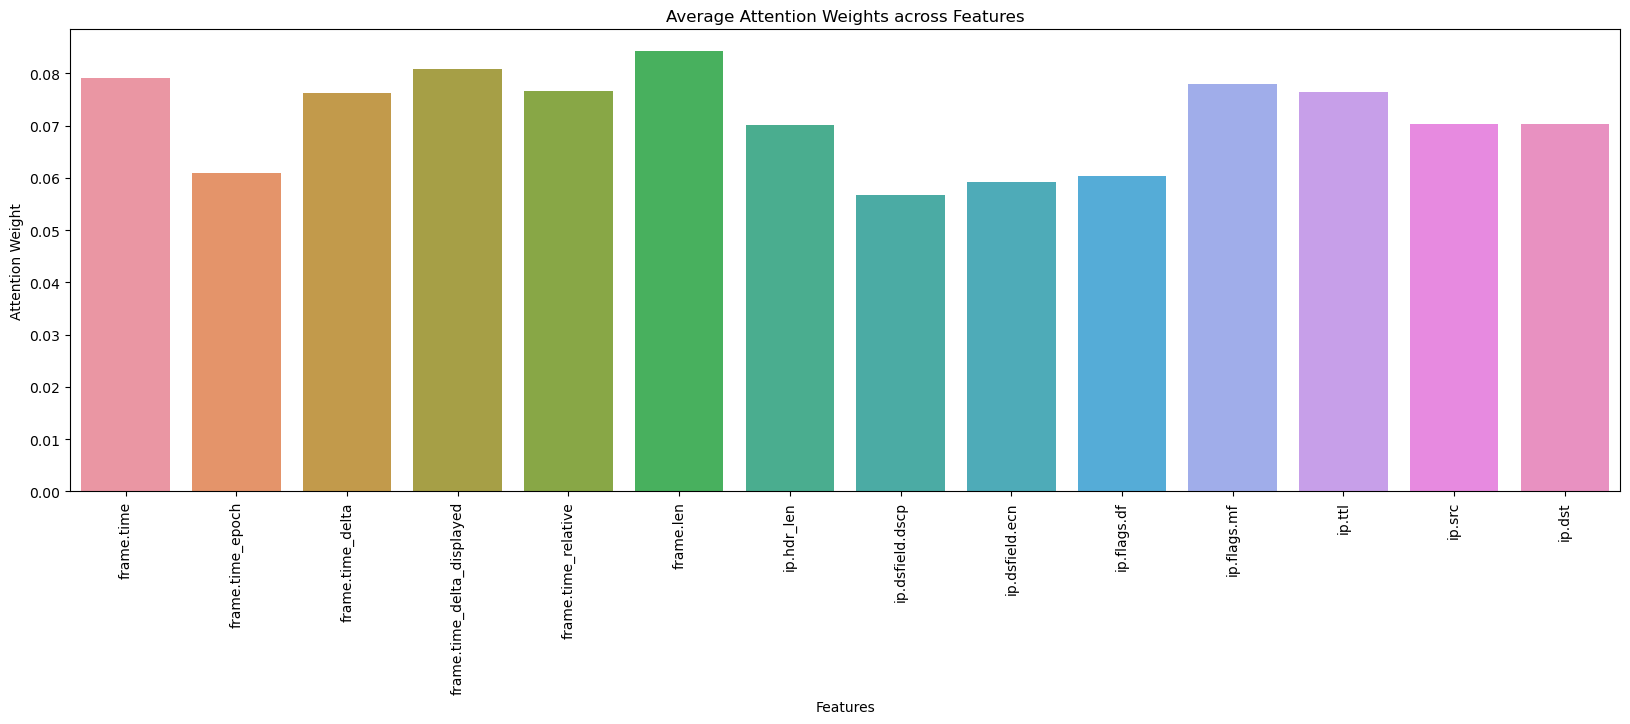

In [62]:
plt.figure(figsize=(20, 6))
sns.barplot(x='Feature', y='Attention Weight', data=attention_df)
plt.title('Average Attention Weights across Features')
plt.xlabel('Features')
plt.ylabel('Attention Weight')
plt.xticks(rotation=90)
plt.savefig('H23Q_attention_weight_binary.png')
plt.show()

9400/9400 ━━━━━━━━━━━━━━━━━━━━ 78s 8ms/step


C:\Users\ramya\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


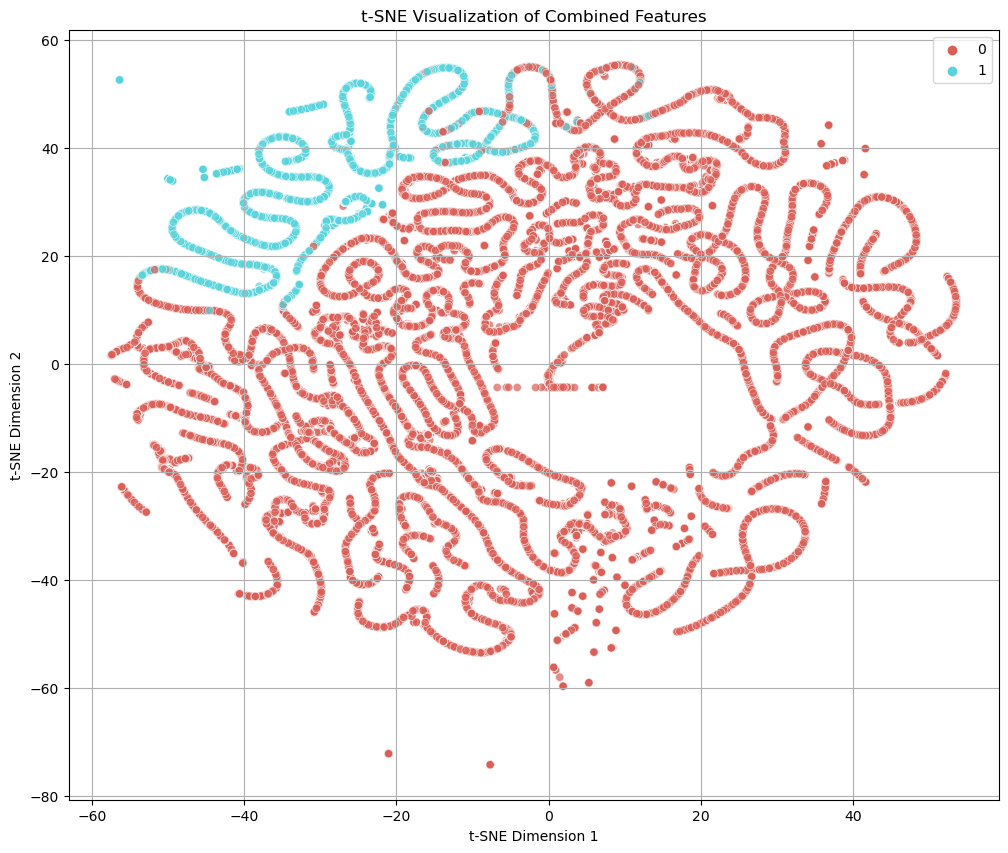

In [50]:
# t-SNE visualization (for binary classification)
from sklearn.manifold import TSNE

# Extract combined features from the ensemble model before the attention mechanism
feature_extractor = Model(inputs=ensemble_model.inputs, outputs=ensemble_model.get_layer('combined_features').output)
combined_features_test = feature_extractor.predict([X_test_cnn, X_test_cnn, X_test])

# Perform t-SNE to reduce the combined features to 2D
tsne = TSNE(n_components=2, perplexity=30, n_iter=3000, random_state=42)
tsne_results = tsne.fit_transform(combined_features_test)

# Create a DataFrame for visualization
tsne_df = pd.DataFrame({
    't-SNE1': tsne_results[:, 0],
    't-SNE2': tsne_results[:, 1],
    'Label': y_test_binary
})

# Plot t-SNE results
plt.figure(figsize=(12, 10))
sns.scatterplot(
    x='t-SNE1', y='t-SNE2',
    hue='Label',
    palette=sns.color_palette('hls', 2),
    data=tsne_df,
    legend='full',
    alpha=0.7
)
plt.title('t-SNE Visualization of Combined Features')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(loc='best')
plt.grid(True)
plt.savefig('UNSW_binary_t-SNE.png')
plt.show()
